(rayleigh)=
# Rayleigh-Wave Phase Velocity

In [1]:
import bayesbay as bb
from bayesbay.discretization import Voronoi1D
import numpy as np
import matplotlib.pyplot as plt
from disba import PhaseDispersion
np.random.seed(30)

In [2]:
THICKNESS = np.array([10, 10, 15, 20, 20, 20, 20, 20, 0])
VS = np.array([3.38, 3.44, 3.66, 4.25, 4.35, 4.32, 4.315, 4.38, 4.5])
VP_VS = 1.77
VP = VS * VP_VS
RHO = 0.32 * VP + 0.77
PERIODS = np.geomspace(3, 80, 20)
RAYLEIGH_STD = 0.02

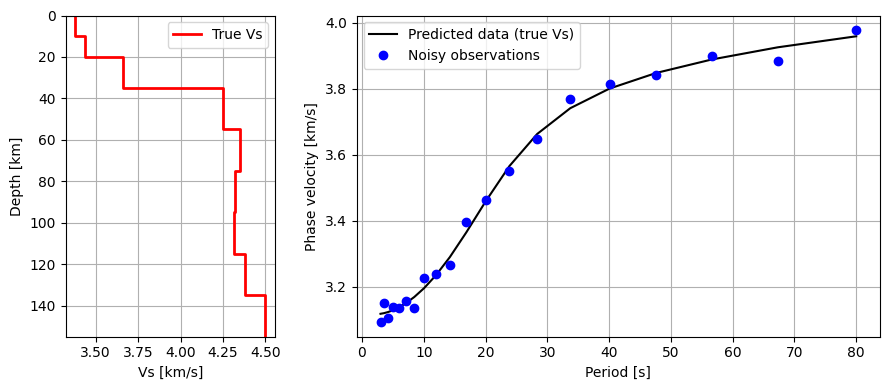

In [3]:
pd = PhaseDispersion(THICKNESS, VP, VS, RHO)
phase_vel = pd(PERIODS, mode=0, wave="rayleigh").velocity
d_obs = phase_vel + np.random.normal(0, RAYLEIGH_STD, phase_vel.size)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={'width_ratios': [1, 2.5]})
ax1 = Voronoi1D.plot_depth_profile(THICKNESS, VS, label='True Vs', ax=ax1, color='r', lw=2)
ax1.set_xlabel('Vs [km/s]')
ax1.set_ylabel('Depth [km]')
ax1.set_ylim(np.cumsum(THICKNESS)[-1] + max(THICKNESS), 0)
ax1.grid()
ax1.legend()

ax2.plot(PERIODS, phase_vel, 'k', label='Predicted data (true Vs)')
ax2.plot(PERIODS, d_obs, 'bo', label='Noisy observations')
ax2.set_xlabel('Period [s]')
ax2.set_ylabel('Phase velocity [km/s]')
ax2.grid()
ax2.legend()

plt.tight_layout(w_pad=2)
plt.show()

In [4]:
def initialize_vs(param, positions=None):
    vmin, vmax = param.get_vmin_vmax(positions)
    sorted_vals = np.sort(np.random.uniform(vmin, vmax, positions.size))
    return sorted_vals

vs = bb.parameters.UniformParameter(name="vs", 
                                    vmin=2.5, 
                                    vmax=5, 
                                    perturb_std=0.15)
vs.set_custom_initialize(initialize_vs)

In [5]:
voronoi = Voronoi1D(
    name="voronoi", 
    vmin=0,
    vmax=150,
    perturb_std=10,
    n_dimensions=None, 
    n_dimensions_min=4,
    n_dimensions_max=15,
    parameters=[vs], 
    birth_from='neighbour'
)
parameterization = bb.parameterization.Parameterization(voronoi)

In [6]:
def forward_sw(model):
    voronoi = model["voronoi"]
    voronoi_sites = voronoi["discretization"]
    thickness = Voronoi1D.compute_cell_extents(voronoi_sites)
    vs = voronoi["vs"]
    vp = vs * VP_VS
    rho = 0.32 * vp + 0.77
    pd = PhaseDispersion(thickness, vp, vs, rho)
    d_pred = pd(PERIODS, mode=0, wave="rayleigh").velocity
    return d_pred

In [7]:
target = bb.Target("rayleigh", 
                   d_obs, 
                   covariance_mat_inv=1/RAYLEIGH_STD**2)

In [8]:
inversion = bb.BayesianInversion(
    parameterization=parameterization, 
    targets=target, 
    fwd_functions=(forward_sw), 
    n_chains=20
)

inversion.run(
    sampler=None, 
    n_iterations=325_000, 
    burnin_iterations=75_000, 
    save_every=500, 
    verbose=False, 
    print_every=30_000
)

In [9]:
for chain in inversion.chains: chain.print_statistics()


Chain ID: 0
TEMPERATURE: 1
EXPLORED MODELS: 325000
ACCEPTANCE RATE: 74286/325000 (22.86 %)
PARTIAL ACCEPTANCE RATES:
	BirthPerturbation(voronoi): 7852/82389 (9.53%)
	DeathPerturbation(voronoi): 7843/72349 (10.84%)
	ParamPerturbation(voronoi.discretization): 27981/85052 (32.90%)
	ParamPerturbation(vs): 30610/85210 (35.92%)
Chain ID: 1
TEMPERATURE: 1
EXPLORED MODELS: 325000
ACCEPTANCE RATE: 76022/325000 (23.39 %)
PARTIAL ACCEPTANCE RATES:
	BirthPerturbation(voronoi): 8249/81463 (10.13%)
	DeathPerturbation(voronoi): 8246/74717 (11.04%)
	ParamPerturbation(voronoi.discretization): 27288/84083 (32.45%)
	ParamPerturbation(vs): 32239/84737 (38.05%)
Chain ID: 2
TEMPERATURE: 1
EXPLORED MODELS: 325000
ACCEPTANCE RATE: 72579/325000 (22.33 %)
PARTIAL ACCEPTANCE RATES:
	BirthPerturbation(voronoi): 7935/80662 (9.84%)
	DeathPerturbation(voronoi): 7931/78371 (10.12%)
	ParamPerturbation(voronoi.discretization): 26422/83093 (31.80%)
	ParamPerturbation(vs): 30291/82874 (36.55%)
Chain ID: 3
TEMPERATURE: 1


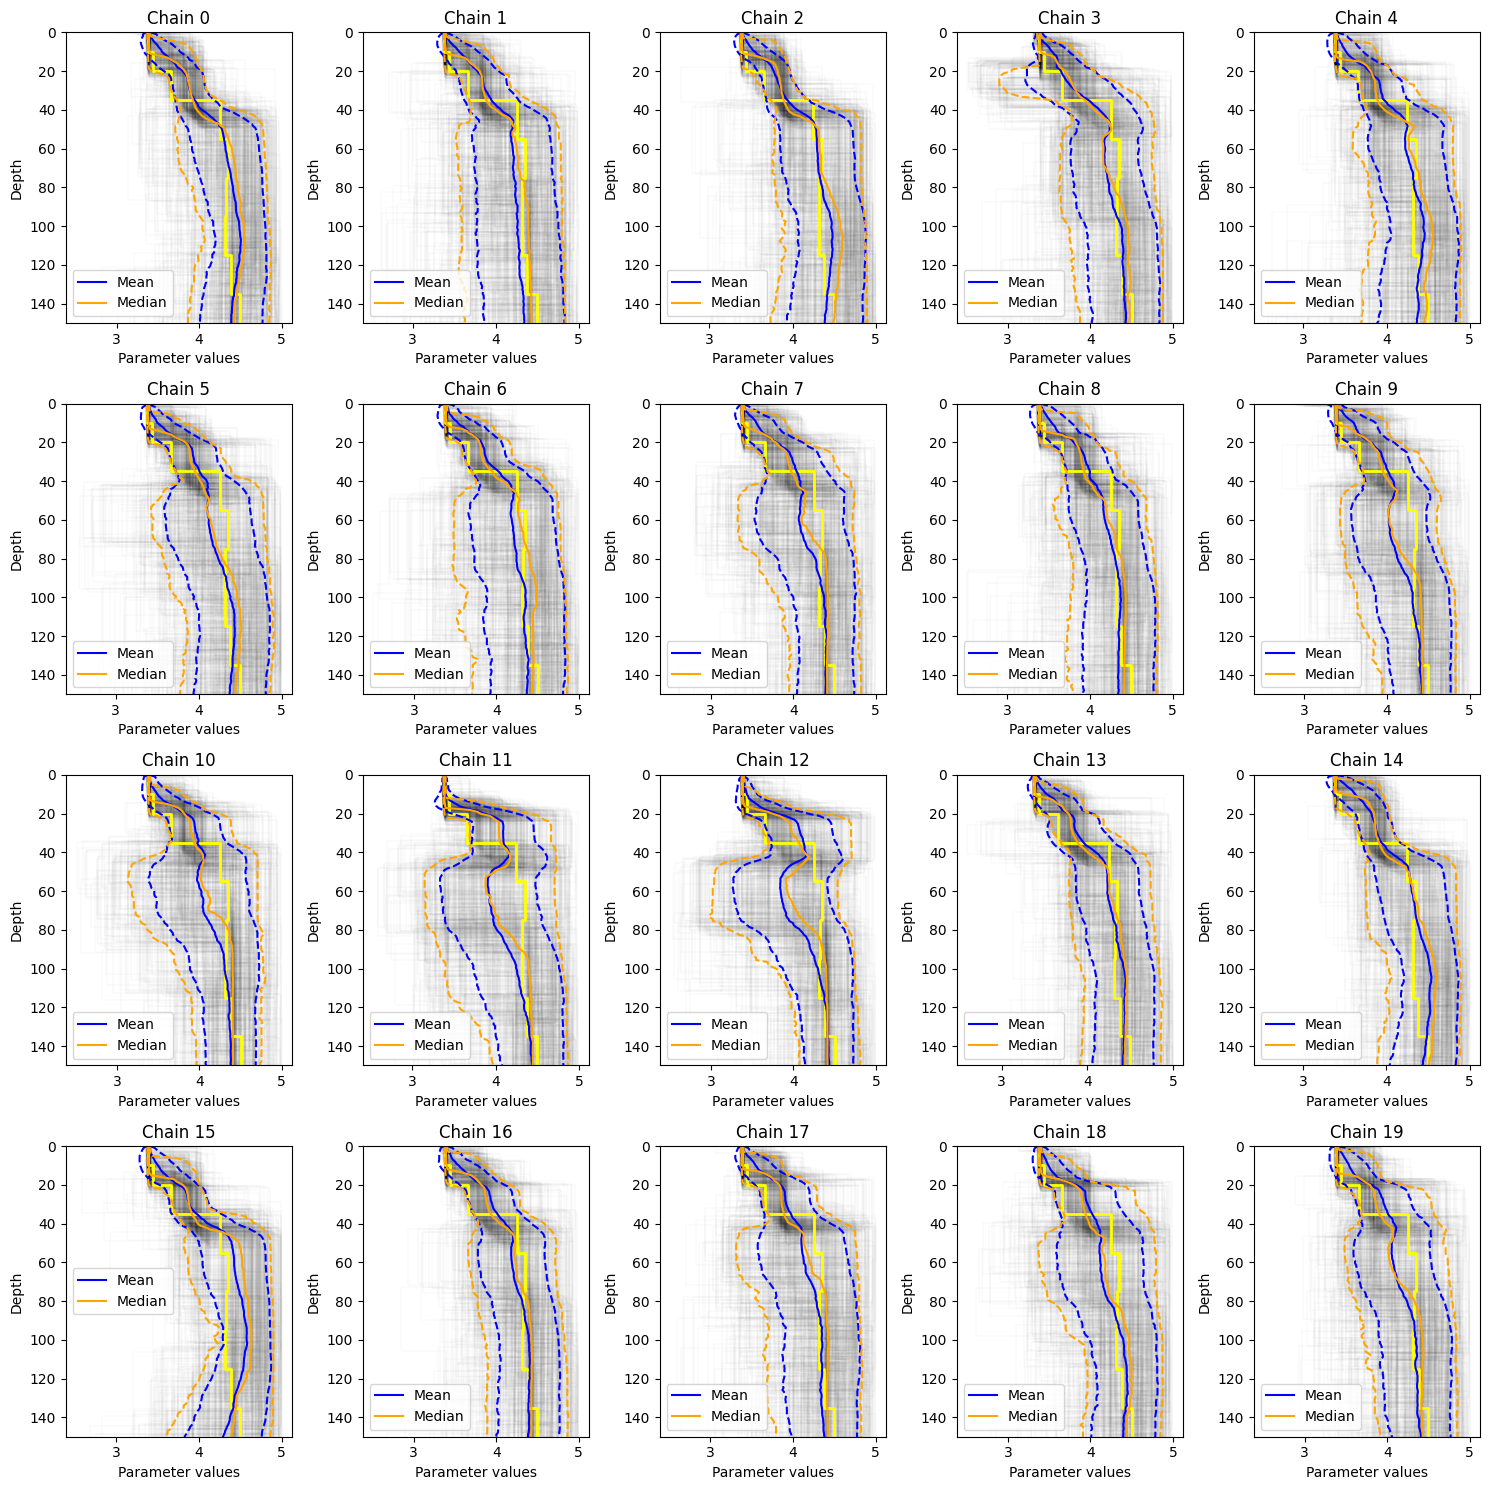

In [10]:
def get_subplot_layout(n_subplots):
    rows = int(np.sqrt(n_subplots))
    cols = int(np.ceil(n_subplots / rows))
    return rows, cols



results = inversion.get_results(concatenate_chains=True)
dpred = np.array(results['dpred'])

sampled_voronoi_nuclei = results['voronoi.discretization']
sampled_vs = results['vs']
interp_depths = np.linspace(0, 160, 160)
statistics_vs = Voronoi1D.get_depth_profiles_statistics(
    all_thicknesses, results["vs"], interp_depths
    )



In [11]:
all_thicknesses = [Voronoi1D.compute_cell_extents(m) for m in results["voronoi.discretization"]]